## Setting

In [2]:
from torchvision import datasets as ds
from torch.utils.data import DataLoader
from torchvision import transforms as ts
import torchvision as tv
import torch
import torch.nn as nn
import math
import numpy as np
from torch.autograd import Variable
from torch import optim
from matplotlib import pyplot as plt
import torch.backends.cudnn as cudnn
import timm
from PIL import Image
from tqdm import tqdm
import random
import os

%config Completer.use_jedi = False

In [4]:
def setseed(seednum = 20):
    torch.manual_seed(seednum)
    torch.cuda.manual_seed(seednum)
    torch.cuda.manual_seed_all(seednum)
    np.random.seed(seednum)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seednum)

In [5]:
setseed(99)

In [6]:
cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if cuda_available else "cpu")
device

device(type='cuda')

## Dataset

In [7]:
transform = ts.Compose(
    [
        ts.ToTensor(),
        ts.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [8]:
train_set = ds.CIFAR10(root='../data/', train=True, transform=transform, download=True)
val_set = tv.datasets.CIFAR10(root='../data/', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False, num_workers=0)

In [10]:
def make_test_list(data_dir):
    
    test_img_list = list()
    
    files = os.listdir(data_dir)
    
    for i in range(10):
        img_file = data_dir + "/" + files[i]
        img = os.listdir(img_file)
        for j in range(200):
            img_path = data_dir + "/" +  files[i] + "/" + img[j]
            
            test_img_list.append(img_path)
    return test_img_list

In [11]:
img_list = make_test_list("../Statistical_Deep_Image_2021/Statistical_Deep_Image")

In [12]:
def make_test_label(label_list):
    
    test_label_list = list()
    
    for i in [0,2,1,3,4,5,6,7,8,9]:
        for j in range(200):
            test_label_list.append(i)
        
    return test_label_list

In [13]:
label = os.listdir("../Statistical_Deep_Image_2021/Statistical_Deep_Image")
img_label_list = make_test_label(label)

In [14]:
class testset(torch.utils.data.Dataset):
    def __init__(self, img_list, img_label_list, transform):
        self.file_list = img_list
        self.labels = img_label_list
        self.transform = transform
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = self.labels[index]
        return img_transformed, label

In [15]:
test_set = testset(img_list = img_list,
                  img_label_list = img_label_list,
                  transform = transform)

In [16]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 64, shuffle=True, num_workers=0)

In [17]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### labeling 확인

In [27]:
import matplotlib.pyplot as plt
import numpy as np

#이미지 확인하기

def imshow(img):
    img = img / 2 + 0.5     # 정규화 해제
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

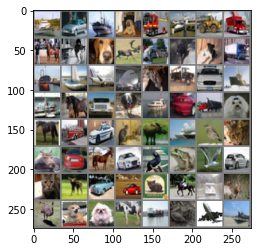

class :  ship label : 8
class :   car label : 1
class :  ship label : 8
class :   dog label : 5
class : truck label : 9
class : plane label : 0
class : truck label : 9
class : truck label : 9
class : horse label : 7
class :   cat label : 3
class :   dog label : 5
class :  deer label : 4
class : horse label : 7
class :   dog label : 5
class :   dog label : 5
class : truck label : 9


In [72]:
# 학습용 이미지 뽑기
dataiter = iter(train_loader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(tv.utils.make_grid(images))

# 이미지별 라벨 (클래스) 보여주기
for i in range(16):
    print('class : %5s' % classes[labels[i]], 'label : %d' %labels[i])

In [1]:
# 학습용 이미지 뽑기
dataiter = iter(test_loader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(tv.utils.make_grid(images))

# 이미지별 라벨 (클래스) 보여주기
for i in range(64):
    print('class : %5s' % classes[labels[i]], 'label : %d' %labels[i])

NameError: name 'test_loader' is not defined

## Model

In [19]:
model = timm.create_model('vgg16', pretrained=False, num_classes=10)

In [20]:
model = model.to(device)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Train

In [23]:
def train(num_epoch):
    best_accuracy = 0.0 
    
    for epoch in tqdm(range(num_epoch)):

        running_train_loss = 0.0
        running_val_loss = 0.0
        true = 0
        total = 0

        for i, data in enumerate(train_loader, 0) :
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
        
        with torch.no_grad():
            model.eval()
            for i, data in enumerate(val_loader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                predicted_outputs = model(inputs)
                val_loss = criterion(predicted_outputs, labels)
                
                _, predicted = torch.max(predicted_outputs, 1) 
                
                running_val_loss += val_loss.item()
                total += labels.size(0)
                true += (predicted == labels).sum().item()
                
        train_loss_per_epoch = running_train_loss / len(train_loader)
        val_loss = running_val_loss/len(val_loader)
        accuracy = (100 * true / total)     
        
        if accuracy > best_accuracy:
            torch.save(model.state_dict(), 'VGG_weights.pth')
            best_accuracy = accuracy
            
        print('epoch: %d' %(epoch+1), ' train_loss: %.3f' %train_loss_per_epoch, ' val_loss: %.4f' %val_loss, ' Accuracy: %d %%' % (accuracy))

In [24]:
train(40)

  2%|▎         | 1/40 [00:55<35:53, 55.21s/it]

epoch: 1  train_loss: 2.139  val_loss: 1.7658  Accuracy: 33 %


  5%|▌         | 2/40 [01:51<35:13, 55.62s/it]

epoch: 2  train_loss: 1.618  val_loss: 1.4135  Accuracy: 46 %


  8%|▊         | 3/40 [02:44<33:47, 54.81s/it]

epoch: 3  train_loss: 1.341  val_loss: 1.3570  Accuracy: 50 %


 10%|█         | 4/40 [03:38<32:37, 54.37s/it]

epoch: 4  train_loss: 1.149  val_loss: 1.1453  Accuracy: 58 %


 12%|█▎        | 5/40 [04:32<31:40, 54.31s/it]

epoch: 5  train_loss: 0.993  val_loss: 1.0620  Accuracy: 62 %


 15%|█▌        | 6/40 [05:27<30:47, 54.33s/it]

epoch: 6  train_loss: 0.868  val_loss: 0.8593  Accuracy: 69 %


 18%|█▊        | 7/40 [06:22<30:02, 54.63s/it]

epoch: 7  train_loss: 0.756  val_loss: 0.8642  Accuracy: 70 %


 20%|██        | 8/40 [07:18<29:18, 54.96s/it]

epoch: 8  train_loss: 0.659  val_loss: 0.8398  Accuracy: 70 %


 22%|██▎       | 9/40 [08:13<28:32, 55.23s/it]

epoch: 9  train_loss: 0.571  val_loss: 0.8073  Accuracy: 73 %


 25%|██▌       | 10/40 [09:08<27:33, 55.13s/it]

epoch: 10  train_loss: 0.492  val_loss: 0.7759  Accuracy: 73 %


 28%|██▊       | 11/40 [10:01<26:14, 54.28s/it]

epoch: 11  train_loss: 0.410  val_loss: 0.8514  Accuracy: 72 %


 30%|███       | 12/40 [10:53<25:02, 53.67s/it]

epoch: 12  train_loss: 0.344  val_loss: 0.9397  Accuracy: 72 %


 32%|███▎      | 13/40 [11:47<24:15, 53.92s/it]

epoch: 13  train_loss: 0.284  val_loss: 0.9149  Accuracy: 74 %


 35%|███▌      | 14/40 [12:42<23:25, 54.06s/it]

epoch: 14  train_loss: 0.249  val_loss: 0.9014  Accuracy: 75 %


 38%|███▊      | 15/40 [13:35<22:23, 53.75s/it]

epoch: 15  train_loss: 0.187  val_loss: 0.9200  Accuracy: 75 %


 40%|████      | 16/40 [14:28<21:27, 53.67s/it]

epoch: 16  train_loss: 0.151  val_loss: 1.0717  Accuracy: 73 %


 42%|████▎     | 17/40 [15:22<20:33, 53.64s/it]

epoch: 17  train_loss: 0.135  val_loss: 1.1641  Accuracy: 75 %


 45%|████▌     | 18/40 [16:15<19:36, 53.48s/it]

epoch: 18  train_loss: 0.121  val_loss: 1.0144  Accuracy: 74 %


 48%|████▊     | 19/40 [17:07<18:33, 53.00s/it]

epoch: 19  train_loss: 0.096  val_loss: 1.1849  Accuracy: 75 %


 50%|█████     | 20/40 [18:01<17:44, 53.21s/it]

epoch: 20  train_loss: 0.088  val_loss: 1.0615  Accuracy: 75 %


 52%|█████▎    | 21/40 [18:54<16:54, 53.38s/it]

epoch: 21  train_loss: 0.064  val_loss: 1.1783  Accuracy: 76 %


 55%|█████▌    | 22/40 [19:46<15:53, 52.96s/it]

epoch: 22  train_loss: 0.060  val_loss: 1.3188  Accuracy: 75 %


 57%|█████▊    | 23/40 [20:38<14:54, 52.62s/it]

epoch: 23  train_loss: 0.059  val_loss: 1.2023  Accuracy: 76 %


 60%|██████    | 24/40 [21:31<14:03, 52.74s/it]

epoch: 24  train_loss: 0.051  val_loss: 1.2523  Accuracy: 75 %


 62%|██████▎   | 25/40 [22:25<13:13, 52.93s/it]

epoch: 25  train_loss: 0.044  val_loss: 1.2622  Accuracy: 76 %


 65%|██████▌   | 26/40 [23:20<12:31, 53.68s/it]

epoch: 26  train_loss: 0.042  val_loss: 1.2809  Accuracy: 77 %


 68%|██████▊   | 27/40 [24:13<11:33, 53.37s/it]

epoch: 27  train_loss: 0.031  val_loss: 1.4824  Accuracy: 75 %


 70%|███████   | 28/40 [25:04<10:34, 52.90s/it]

epoch: 28  train_loss: 0.039  val_loss: 1.3863  Accuracy: 76 %


 72%|███████▎  | 29/40 [25:56<09:36, 52.39s/it]

epoch: 29  train_loss: 0.034  val_loss: 1.3582  Accuracy: 76 %


 75%|███████▌  | 30/40 [26:47<08:42, 52.21s/it]

epoch: 30  train_loss: 0.022  val_loss: 1.5008  Accuracy: 76 %


 78%|███████▊  | 31/40 [27:39<07:49, 52.13s/it]

epoch: 31  train_loss: 0.031  val_loss: 1.3711  Accuracy: 76 %


 80%|████████  | 32/40 [28:32<06:58, 52.27s/it]

epoch: 32  train_loss: 0.032  val_loss: 1.3883  Accuracy: 77 %


 82%|████████▎ | 33/40 [29:25<06:06, 52.34s/it]

epoch: 33  train_loss: 0.022  val_loss: 1.4721  Accuracy: 77 %


 85%|████████▌ | 34/40 [30:17<05:13, 52.27s/it]

epoch: 34  train_loss: 0.017  val_loss: 1.5783  Accuracy: 75 %


 88%|████████▊ | 35/40 [31:11<04:24, 52.99s/it]

epoch: 35  train_loss: 0.026  val_loss: 1.3759  Accuracy: 77 %


 88%|████████▊ | 35/40 [31:26<04:29, 53.89s/it]


KeyboardInterrupt: 

In [23]:
# 모델 가중치 저장
#torch.save(model.state_dict(), 'model_weights.pth')

#모델 가중치 불러오기
#model.load_state_dict(torch.load('VGG_weights.pth'))
#model.eval()

## Test

In [25]:
model.load_state_dict(torch.load('VGG_weights.pth'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [28]:
correct = 0
total = 0

with torch.no_grad():
    for data in tqdm(test_loader):
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy: %d %%' % (100 * correct / total))

100%|██████████| 32/32 [00:00<00:00, 33.64it/s]

Accuracy: 45 %
